# CO416 - Machine Learning for Imaging

## Tutorial 1 - Image processing with Python

In this tutorial, we will learn basics of image IO and simple processing, and visualisation in Python. 
If you want to refresh your python basics, please check this [tutorial](http://cs231n.github.io/python-numpy-tutorial/) from the computer vision course at Stanford.

By the end of the tutorial, you should be able to:
1. Use python, numpy, and run jupyter notebook
2. Build a simple binary classifier 
3. Implement a logistic regression classifier using numpy

---


In [1]:
# import common libraries
import numpy as np

# import some helper code
import sys
sys.path.append('code')
from mli import plot_digit, plot_digits

# adjust settings to plot nice figures inline
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# data directory
# data_dir = '/home/kendeas93/Desktop/mli-tutorials/mnist'
data_dir = '/vol/lab/course/416/data/mnist'

---

## ML Project Example - Image Classification

In a real ML task, data would be available in a database and organised in tables, documents or files. In this tutorial, we will be using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/), small images of digits handwritten by high school students and employees of the US Census Bureau. It consists of a training set of 60,000 examples, and a test set of 10,000 examples. Each image is size-normalized and centered in a fixed-size image 28x28 pixels, and labeled with the digit it represents. It is kind of the *hello world* of machine learning for imaging. You can find more benchmark datasets [here](https://pytorch.org/docs/stable/torchvision/datasets.html)


Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: /vol/lab/course/416/data/mnist
    Transforms (if any): None
    Target Transforms (if any): None
Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: /vol/lab/course/416/data/mnist
    Transforms (if any): None
    Target Transforms (if any): None


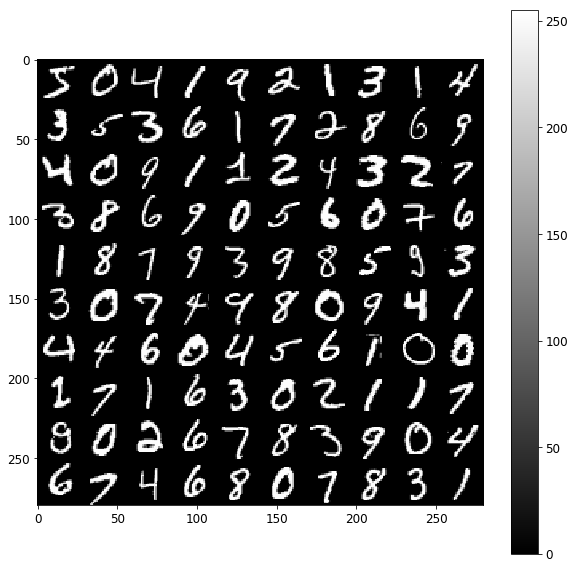

In [2]:
import torchvision.datasets as dset

# train data
train_set = dset.MNIST(root=data_dir, train=True, download=False)
train_data = np.array(train_set.train_data)
train_labels = np.array(train_set.train_labels)

# test data
test_set = dset.MNIST(root=data_dir, train=False, download=False)
test_data = np.array(test_set.test_data)
test_labels = np.array(test_set.test_labels)

# print train and test data details
print(train_set)
print(test_set)

# plot sample digits
plot_digits(train_set.train_data[:100])
plt.show()

---
Here, we will sort our data and fix the random seed to ensure geting same results everytime you run the experiments. Then plot some sampled digits after sorting the data.

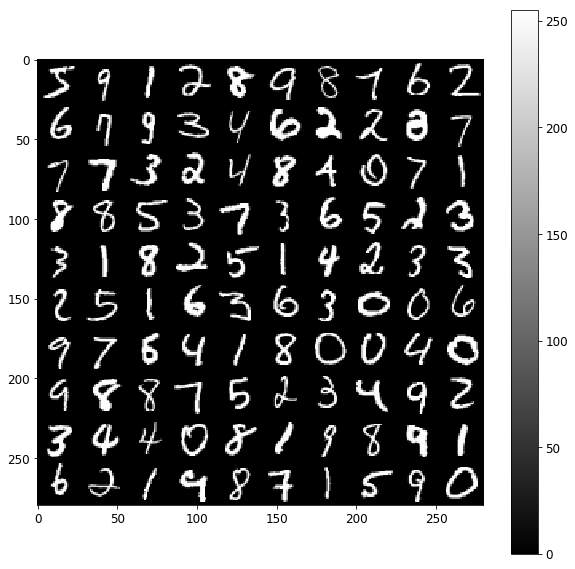

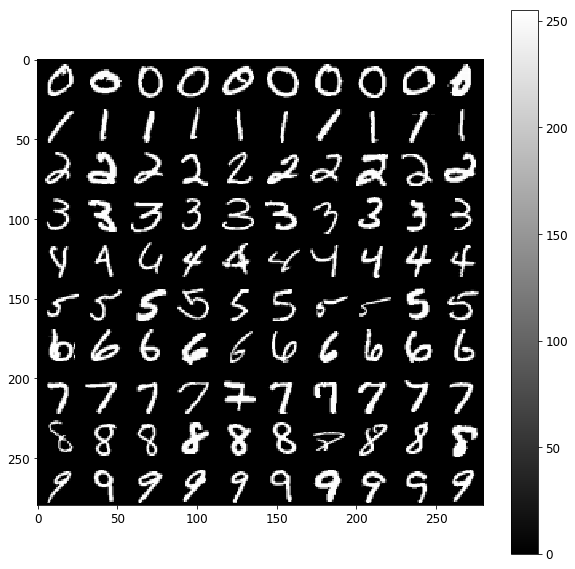

In [3]:
# we will sort our data and fix the random generator seed to get similar results from different runs
np.random.seed(42)

# sort dataset
def sort_data(data, labels):
    sorted_idxs = np.array(sorted([(target, i) for i, target in enumerate(labels)]))[:, 1]
    return data[sorted_idxs], labels[sorted_idxs]

############################################################################
# Q: use the previous function to sort both traininf and testing data
############################################################################
sorted_train_data, sorted_train_labels = sort_data(train_data, train_labels)
sorted_test_data, sorted_test_labels = sort_data(test_data, test_labels)
############################################################################

# plot sampled images from sorted data
# here it samples 20 samples of [0,1], 30 samples of [2,3,4], and 50 samples of [5,6,7,8,9] - 10 samples for each digit
example_images = np.r_[train_data[:12000:600], train_data[13000:30600:600], train_data[30600:60000:590]]
plot_digits(example_images)

# Plot sorted data
sorted_train_images = np.r_[sorted_train_data[:12000:600], sorted_train_data[13000:30600:600], sorted_train_data[30600:60000:590]]
plot_digits(sorted_train_images)
plt.show()

---
### Simple Binary Classifier

Now our data are cleaned and sorted, we will train a simple binary classifier to distinguish between two selected digits. 

Data usually is divided into three sets for training, validation, and testing. The training data is used to train the model's parameters, while the validation set is used to adjust the model's hyperparameters. Finally, the performance of the trained model is evaluated on the testing data. For this tutorial we will split the data into train and test for simplification. 

**Task - 01**

1. Extract ones and eights from both training and testing data
2. Shuffle training data
3. Plot number of images versus number of 'white' pixels per image
4. Can you predict the label based only on the number of 'white' pixels? What's the training and testing error for such an approach?

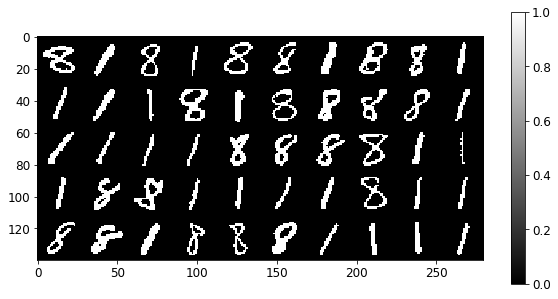

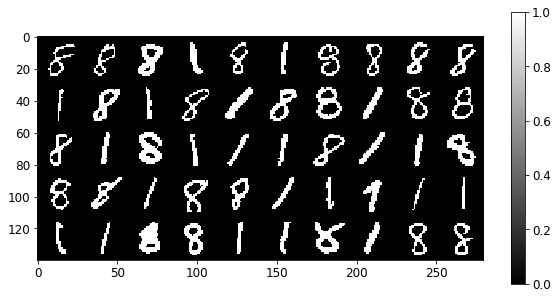

In [4]:
############################################################################
# Extract sample digits of ones and eights
############################################################################

def sample_data_digits(data, labels, selected_digits):
    # convert input 3d arrays to 2d arrays
    nsamples, nx, ny = data.shape
    data_vec = np.reshape(data,(nsamples,nx*ny))

    selected_indexes = np.isin(labels, selected_digits)
    selected_data = data_vec[selected_indexes]
    selected_labels = labels[selected_indexes]
    
    # Convert images from gray to binary by thresholding intensity values
    selected_data = 1.0 * (selected_data >= 128)

    # convert labels to binary: digit_1=False, digit_2=True
    selected_labels = selected_labels==selected_digits[1]
    
    # shuffle data
    shuffle_index = np.random.permutation(len(selected_labels))
    selected_data, selected_labels = selected_data[shuffle_index], selected_labels[shuffle_index]
    
    return selected_data, selected_labels


############################################################################
# Q: extract ones and eights digits from both training and testing data 
############################################################################
selected_labels = [1, 8]
selected_train_data, selected_train_labels = sample_data_digits(train_data, train_labels, selected_labels)
selected_test_data, selected_test_labels = sample_data_digits(test_data, test_labels, selected_labels)
############################################################################
# plot sampled digits
plot_digits(selected_train_data[0:50])
plt.show()
plot_digits(selected_train_data[8000:8050])
plt.show()

[ 88.  34. 101. ...  42.  32.  50.]
[160.  98. 127. ...  70. 176. 137.]


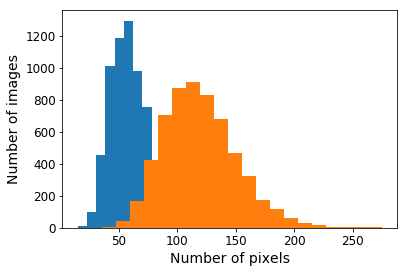

In [5]:
############################################################################
# Q:plot number of images versus number of 'white' foreground pixels 
# for both 1s and 8s classes
############################################################################
# sorted_selected, sorted_ones_labels = sort_data(selected_train_data, selected_train_labels)
# plot_digits(sorted_selected[0:50])
# plot_digits(sorted_selected[8000:8050])
# plt.show()
selected_ones = selected_train_data[selected_train_labels==0]
selected_eights = selected_train_data[selected_train_labels==1]
num_ones = len(selected_ones)
num_eights = len(selected_eights)

white_ones = np.sum(selected_ones, axis = 1)
white_eights = np.sum(selected_eights, axis = 1)
print(white_ones)
print(white_eights)

# Histogram
plt.hist(white_ones, bins = 20)
plt.hist(white_eights, bins = 20)
plt.xlabel('Number of pixels')
plt.ylabel('Number of images')
plt.show()

In [6]:
############################################################################
# Q: select threshold value to seperate between the two classes
############################################################################
threshold = 80

In [7]:
############################################################################
# Q: classify digits using a threshold 
############################################################################
def classify_digits(digits, threshold):
    # Class 0 is one
    # Class 1 is eight
    classes = np.sum(digits, axis = 1)
    classes[classes <= threshold] = 0
    classes[classes > threshold] = 1
    return classes

In [8]:
############################################################################
# Q: calculate both training and testing accuracy
# You should get accuracies around 89-90%
############################################################################

train_pred = classify_digits(selected_train_data, threshold)
test_pred = classify_digits(selected_test_data, threshold)

train_accuracy = np.sum(train_pred == selected_train_labels) / selected_train_labels.shape[0]
test_accuracy = np.sum(test_pred == selected_test_labels) / selected_test_labels.shape[0]
print('Accuracy on training data:', train_accuracy)
print('Accuracy on testing data:', test_accuracy)

Accuracy on training data: 0.8930358135472087
Accuracy on testing data: 0.8999525841631105


---
**Task - 02**
Repeat the previous examples to classify digits 0s and 8s instead of 1s and 8s. Will the threshold binary classifier differentiate between the two categories based on number of 'white' pixels?

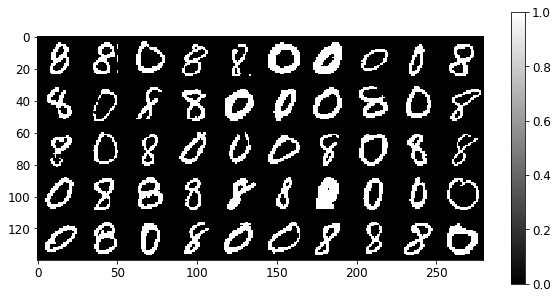

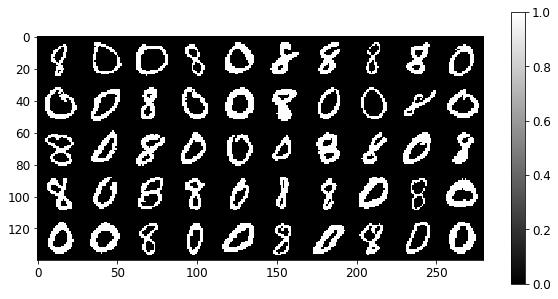

[131. 217. 230. ...  56. 218. 149.]
[127. 134. 114. ... 101. 117.  80.]


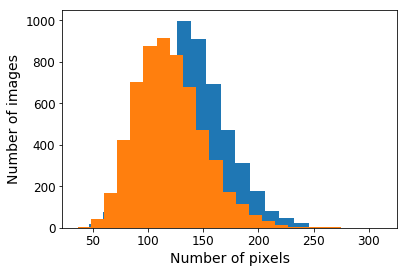

Accuracy on training data: 0.3804144725666723
Accuracy on testing data: 0.39969293756397134


In [9]:
############################################################################
# Q: extract zeros and eights digits from both training and testing data 
############################################################################
selected_labels = [0, 8]
selected_train_data2, selected_train_labels2 = sample_data_digits(train_data, train_labels, selected_labels)
selected_test_data2, selected_test_labels2 = sample_data_digits(test_data, test_labels, selected_labels)
############################################################################
# plot sampled digits
plot_digits(selected_train_data2[0:50])
plt.show()
plot_digits(selected_train_data2[8000:8050])
plt.show()

selected_zeros = selected_train_data2[selected_train_labels2==0]
selected_eights = selected_train_data2[selected_train_labels2==1]
num_ones = len(selected_zeros)
num_eights = len(selected_eights)

white_zeros = np.sum(selected_zeros, axis = 1)
white_eights = np.sum(selected_eights, axis = 1)
print(white_zeros)
print(white_eights)

# Histogram
plt.hist(white_zeros, bins = 20)
plt.hist(white_eights, bins = 20)
plt.xlabel('Number of pixels')
plt.ylabel('Number of images')
plt.show()

# New threshold
threshold2 = 130

train_pred = classify_digits(selected_train_data2, threshold2)
test_pred = classify_digits(selected_test_data2, threshold2)

train_accuracy = np.sum(train_pred == selected_train_labels2) / selected_train_labels2.shape[0]
test_accuracy = np.sum(test_pred == selected_test_labels2) / selected_test_labels2.shape[0]
print('Accuracy on training data:', train_accuracy)
print('Accuracy on testing data:', test_accuracy)

---
## Logistic Regression using Numpy

In the previous example, we used a simple threshold to classify each image of a digit using one feature (number of 'white' pixels). Here, we will use a logistic regression model for this task. The logistic regression function is defined as: $h_{\Theta}(\mathbf{x}) =  \frac{1}{1 + \exp(-\theta^{\top} \mathbf{x})}$.

Training our model is a loop that includes three main steps
1. Evaluate the cost function $J(\Theta)$
2. Compute partial derivatives
3. Update the model paramteters

Details can be found in slides 24-34, of Lecture 2.

---

**Task - 03**

1. Complete the logistic regression class below 
2. Train a logistic regression model on the data from the previous example
3. Compute train and test accuracies, and compare with the previous results
4. Plot the trained parameters and comment on the figure

In [68]:
class LogisticRegression:
    def __init__(self, lr=0.05, num_iter=1000, add_bias=True, verbose=True):
        self.lr = lr
        self.verbose = verbose
        self.num_iter = num_iter
        self.add_bias = add_bias
        self.weights = None
    
    def __add_bias(self, X):
        bias = np.ones((X.shape[0], 1))
        return np.concatenate((bias, X), axis=1)
    
    def sigmoid(self, X):
        z = np.dot(self.weights.T, X.T)
        return 1 / (1 + np.exp(-z))
        
    def grad(self, h, y, X):
        return np.dot(h - y.T, X) / len(X)
    
    def __loss(self, h, y):
        ''' computes loss values '''
        y = np.array(y,dtype=float)
        ############################################################################
        # Q: compute the loss 
        ############################################################################
        loss = (-y * np.log(h)) - ((1-y) * np.log(1-h))
        return np.sum(loss) / len(y)
    
    def fit(self, X, y):
        ''' 
        Optimise our model using gradient descent
        Arguments:
            X input features
            y labels from training data
            
        '''
        if self.add_bias:
            X = self.__add_bias(X)
        ############################################################################
        # Q: initialise weights randomly with normal distribution N(0,1)
        ############################################################################
        self.weights = np.random.normal(0, 1, X.shape[1])
        for i in range(self.num_iter):
            ############################################################################
            # Q: forward propagation
            ############################################################################
            preds = self.predict_probs(X)
            ############################################################################
            # Q: backward propagation
            ############################################################################
            h = self.sigmoid(X)
            m = len(X)
#             stabilizer = np.sqrt(10**-6)
            gradient = self.grad(h, y, X)
            self.weights -= self.lr * gradient
            ############################################################################
            # Q: print loss
            ############################################################################
            if(self.verbose == True and i % 50 == 0):
                print('Loss at iteration {}: {}'.format(i, self.__loss(h, y)))
    
    def predict_probs(self,X):
        ''' returns output probabilities
        '''
        ############################################################################
        # Q: forward propagation
        ############################################################################
        return np.dot(X, self.weights)
        
    def predict_class(self, X, threshold=0.5):
        ''' returns output classes
        '''
        return self.predict_probs(X) >= threshold


In [69]:
#########################################################################
# Q: train our model
#########################################################################
logistic_model = LogisticRegression(add_bias=False)
logistic_model.fit(selected_train_data, selected_train_labels)

Loss at iteration 0: 2.3186887223895885
Loss at iteration 50: 0.8574982398619816
Loss at iteration 100: 0.5615481086528463
Loss at iteration 150: 0.4403579298171726
Loss at iteration 200: 0.3722791628546689
Loss at iteration 250: 0.32825163476124414


/vol/lab/course/416/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log
/vol/lab/course/416/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in multiply


Loss at iteration 300: nan
Loss at iteration 350: nan
Loss at iteration 400: nan
Loss at iteration 450: nan
Loss at iteration 500: nan
Loss at iteration 550: nan
Loss at iteration 600: nan
Loss at iteration 650: nan
Loss at iteration 700: nan
Loss at iteration 750: nan
Loss at iteration 800: nan
Loss at iteration 850: nan
Loss at iteration 900: nan
Loss at iteration 950: nan


In [70]:
#########################################################################
# Q: Evaluate the trained model - compute train and test accuracies
# You should get accuracies around 95%
#########################################################################
train_pred = logistic_model.predict_class(selected_train_data)
test_pred = logistic_model.predict_class(selected_test_data)

train_accuracy = np.sum(train_pred == selected_train_labels) / selected_train_labels.shape[0]
test_accuracy = np.sum(test_pred == selected_test_labels) / selected_test_labels.shape[0]
print('Accuracy on training data:', train_accuracy)
print('Accuracy on testing data:', test_accuracy)
print(logistic_model.weights.shape)

Accuracy on training data: 0.9532279838005241
Accuracy on testing data: 0.9696538643907064
(784,)


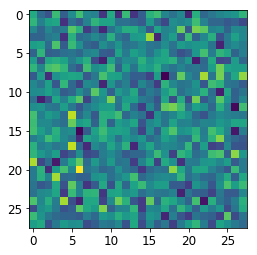

In [74]:
#########################################################################
# Q: plot trained model params (weights) as an image of size (28x28)
#########################################################################
plt.imshow(logistic_model.weights.reshape(28,28))
plt.show()

---
#### Bonus
- Plot both train and test error during training. How's this plot related to the variance/bias trade off? Over- and under-fitting?
- Apply the logistic regression classifier on all digits (multi-class). Comment on the results.
